# Deep Learning in Active Magnetic Regenerators

This Notebook presents the results for the application of Neural Networks in the prediction of the Cooling Capacity ($\dot{Q}_\mathrm{C}$ or $Qc$) and the Magnetization Power ($\dot{W}_\mathrm{m}$ or $Wm$) of Active Magnetic Regenerators. The Dataset consists in 532 points coming from numerical simulations.

### Importing the Modules

In [25]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import pathlib

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import joblib

tf.config.optimizer.set_jit(True)
mpl.style.use('default')
plt.rc('text',usetex = True)
plt.rc('font', family='serif',size = 12)

### Plotting Functions 

In [2]:
def plot_results(y_train,y_pred_train,y_test,y_pred_test,Obj):
    
    plt.figure()
    plt.plot(y_train,y_pred_train,'.',markersize = 7,color = '#1f77b4', mfc='none', label = 'Training Set')
    plt.plot(y_test,y_pred_test,'x' ,markersize = 5, color = '#2ca02c', mfc='none',label = 'Test Set',)
    
    if Obj == 'Qc':
        Aux = np.linspace(50,300)
        plt.plot(Aux,0.95*Aux,'k--')
        plt.plot(Aux,1.05*Aux,'k--')
        plt.text(140, 180, '$+ 5 \%$', fontsize=12)
        plt.text(150, 120, '$- 5 \%$', fontsize=12)
        plt.legend()
        plt.ylabel(r' $\dot{Q}_\mathrm{C}$ [W] - NN' )
        plt.xlabel(r' $\dot{Q}_\mathrm{C}$ [W] - Target')
        plt.grid(linestyle='dotted')
        plt.savefig('Plots/Qc/Qc - NN.png', format = 'png', bbox_inches='tight') 
    
    elif Obj == 'Wm':
        Aux = np.linspace(10,60)
        plt.plot(Aux,0.95*Aux,'k--')
        plt.plot(Aux,1.05*Aux,'k--')
        plt.text(23, 17, '$- 5 \%$', fontsize=12)
        plt.text(19, 28, '$+ 5 \%$', fontsize=12)
        plt.legend()
        plt.ylabel(r' $\dot{W}_\mathrm{AMR,Mag}$ [W] - NN' )
        plt.xlabel(r' $\dot{W}_\mathrm{AMR,Mag}$ [W] - Target')
        plt.grid(linestyle='dotted')
        plt.savefig('Plots/Wm/Wm - NN.png', format = 'png', bbox_inches='tight') 

### Reading the Input Parameteres 

The independent variable are the Width ($H$), Height ($H$) and Length ($L$) of the porous medium, the frequency ($f$) and mass flow rate ($mf$) of the Active Magnetic Regenerator, the Inlet Temperatures at the Hot ($Th$) and Cold ($Tc$) ends and the Applied Magnetic Field ($B$).

The dependent variables are the Cooling Capacity ($Qc$) and Magnetization Power ($Wm$).

In [3]:
Inputs = pd.read_excel('Data/Data_AMR.xlsx',index_col = 0, dtype=np.float32) # Input Data
X = Inputs[['W','H','f','mf','B','L','Th','Tc']]
y = Inputs[['Qc','Wm']]

### Train-Test Split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42)  

### Scaling the Features

In [5]:
sc = joblib.load('Models/AMR_Scaler.pkl')
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [6]:
#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

In [7]:
#joblib.dump(sc, 'Models/AMR_Scaler.pkl') 

### Building the Model

In [8]:
def Build(hp):
    
    #Grouping a stack of Layers in Model
    model = tf.keras.Sequential()
    model.add(BatchNormalization())
    # Adding the Layers
    # The number of layers, neurons in each one and activation functions are going to be tunned 
    for i in range(hp.Int('layers', 0, 2)):
        model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i), 1, 201, step=2),
                                        activation=hp.Choice('act_' + str(i), ['relu','sigmoid','selu'])))
        #model.add(Dropout(0.2))
        #Applying a Batch Normalization Layer after Dense Layer
        model.add(BatchNormalization())

        
    # Adding a final Layer 
    model.add(tf.keras.layers.Dense(1, activation='selu'))
    
    #model = tfmot.quantization.keras.quantize_model(model)
    # Compiling the Model with the Adam optimization algorithm
    model.compile(optimizer=Adam(),
                            loss="mean_squared_error",
                            #metrics=['accuracy']
                            metrics = ['accuracy']
                            )
    return model

### Batch Optimization

Overriding run_trial in MyTuner (https://kegui.medium.com/how-to-tune-the-number-of-epochs-and-batch-size-in-keras-tuner-c2ab2d40878d)

In [9]:
class MyTuner(kt.Hyperband):
    def run_trial(self, trial, *args, **kwargs):
        kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 1, 501, step=5)
        super(MyTuner, self).run_trial(trial, *args, **kwargs)

### Defining the Tuner

In [120]:
def NeuNet(X_train,y_train,max_epochs,Obj):
    
    # Defining the Tuner
    tuner = MyTuner(Build,
                    objective = 'val_loss',
                    max_epochs = max_epochs,
                    directory='KT_Dir',
                    project_name='KT_Hyperband_' + Obj,
                    executions_per_trial = 1,   
    )
    
    # Hyperparameter Optimization
    tuner.search(X_train,
                 y_train[Obj],
                 epochs=max_epochs,
                 #callbacks=[EarlyStopping('val_loss', patience=5)],
                 verbose=1,
                 validation_split=0.2)
    
  
    # Trainning the Best Model
    best_model = tuner.get_best_models()[0]
    best_model.build(X_train.shape)
    best_model.fit(X_train,
                   y_train[Obj], 
                   epochs=max_epochs,
                   batch_size=tuner.get_best_hyperparameters(num_trials=1)[0].get('batch_size')
    )
    best_model.summary()
    
    # Saving the Model
    best_model.save('Models/'+Obj+'/'+ Obj +'_NN.h5', include_optimizer=False)
    best_model.save('Models/'+Obj+'/'+ Obj +'_NN', include_optimizer=False)
    best_model.save_weights('Models/'+Obj+'/'+ Obj +'_weights.h5')
    #joblib.dump(best_model, 'Models/'+Obj+'/'+ Obj +'_NN.pkl')
    
     #R2 for the Training Set
    print('The coefficient of determination for '+ Obj +' Training Set using Neural Networks is '+
          str(r2_score(y_train[Obj], best_model.predict(X_train))))

    # R2 for the Test Set
    print('The coefficient of determination for '+ Obj +' Test Set using Neural Networks is '+
          str(r2_score(y_test[Obj], best_model.predict(X_test)))) 

    # Plotting the Results
    plot_results(y_train[Obj], best_model.predict(X_train), y_test[Obj], best_model.predict(X_test), Obj) 

### Defining a Test Function

In [121]:
def Test(X_train,y_train,Obj, Scal):
    
    Model = load_model('Models/'+Obj+'/'+ Obj +'_NN.h5', compile = False)
    Model.summary()
    #R2 for the Training Set
    print('The coefficient of determination for '+ Obj +' Training Set using Neural Networks is '+
          str(r2_score(y_train[Obj], Model.predict(Scal.transform(X_train)))))

    # R2 for the Test Set
    print('The coefficient of determination for '+ Obj +' Test Set using Neural Networks is '+
          str(r2_score(y_test[Obj], Model.predict(Scal.transform(X_test))))) 

    # Plotting the Results
    plot_results(y_train[Obj], Model.predict(Scal.transform(X_train)), y_test[Obj], Model.predict(Scal.transform(X_test)), Obj) 

In [122]:
def Test_lite(X_train,y_train,Obj, Scal):
    
    Model = load_model('Models/'+Obj+'/'+ Obj +'_NN.h5', compile = False)
    Model.summary()
    
    converter = tf.lite.TFLiteConverter.from_keras_model(Model)
    tflite_model = converter.convert()
    tflite_models_dir = pathlib.Path("/")
    tflite_models_dir.mkdir(exist_ok=True, parents=True)
    tflite_model_file = tflite_models_dir/"mnist_model.tflite"
    tflite_model_file.write_bytes(tflite_model)
    
    interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
    interpreter.allocate_tensors()
    
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    
    Train_Lite = []
    for i in range(np.shape(X_train)[0]):
        interpreter.set_tensor(input_index, Scaller.transform(X_train)[i].reshape(-1,1).T)
        interpreter.invoke()
        Train_Lite.append(interpreter.get_tensor(output_index)[0][0])
        
    Test_Lite = []
    for i in range(np.shape(X_test)[0]):
        interpreter.set_tensor(input_index, Scaller.transform(X_test)[i].reshape(-1,1).T)
        interpreter.invoke()
        Test_Lite.append(interpreter.get_tensor(output_index)[0][0])
    
    #R2 for the Training Set
    print('The coefficient of determination for '+ Obj +' Training Set using Neural Networks is '+
          str(r2_score(y_train[Obj], Train_Lite)))

    # R2 for the Test Set
    print('The coefficient of determination for '+ Obj +' Test Set using Neural Networks is '+
          str(r2_score(y_test[Obj], Test_Lite)))    
    
    # Plotting the Results
    plot_results(y_train[Obj], Train_Lite, y_test[Obj], Test_Lite, Obj) 

### Training the Models

INFO:tensorflow:Reloading Oracle from existing project KT_Dir\KT_Hyperband_Qc\oracle.json


INFO:tensorflow:Reloading Oracle from existing project KT_Dir\KT_Hyperband_Qc\oracle.json


INFO:tensorflow:Reloading Tuner from KT_Dir\KT_Hyperband_Qc\tuner0.json


INFO:tensorflow:Reloading Tuner from KT_Dir\KT_Hyperband_Qc\tuner0.json


INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Epoch 1/1000
6/6 [==============================] - 1s 2ms/step - loss: 34.9920 - accuracy: 0.0000e+00
Epoch 2/1000
6/6 [==============================] - 0s 3ms/step - loss: 30.9855 - accuracy: 0.0000e+00
Epoch 3/1000
6/6 [==============================] - 0s 2ms/step - loss: 64.5394 - accuracy: 0.0000e+00
Epoch 4/1000
6/6 [==============================] - 0s 2ms/step - loss: 62.9028 - accuracy: 0.0000e+00
Epoch 5/1000
6/6 [==============================] - 0s 2ms/step - loss: 46.9912 - accuracy: 0.0000e+00
Epoch 6/1000
6/6 [==============================] - 0s 2ms/step - loss: 44.7548 - accuracy: 0.0000e+00
Epoch 7/1000
6/6 [==============================] - 0s 2ms/step - loss: 46.5401 - accuracy: 0.0000e+00
Epoch 8/1000
6/6 [==============================] - 0s 2ms/step - loss: 41.1641 - accuracy: 0.0000e+00
Epoch 9/1000
6/6 [==============================] - 0s 2ms/step - loss: 60.1919 - accuracy: 0.0000e+00
Epoch 10/1000
6/6 [==============================] - 0s 2ms/step - loss: 

6/6 [==============================] - 0s 2ms/step - loss: 39.1447 - accuracy: 0.0000e+00
Epoch 80/1000
6/6 [==============================] - 0s 2ms/step - loss: 37.8897 - accuracy: 0.0000e+00
Epoch 81/1000
6/6 [==============================] - 0s 2ms/step - loss: 27.8344 - accuracy: 0.0000e+00
Epoch 82/1000
6/6 [==============================] - 0s 2ms/step - loss: 35.3706 - accuracy: 0.0000e+00
Epoch 83/1000
6/6 [==============================] - 0s 2ms/step - loss: 51.6386 - accuracy: 0.0000e+00
Epoch 84/1000
6/6 [==============================] - 0s 2ms/step - loss: 39.3845 - accuracy: 0.0000e+00
Epoch 85/1000
6/6 [==============================] - 0s 2ms/step - loss: 19.6501 - accuracy: 0.0000e+00
Epoch 86/1000
6/6 [==============================] - 0s 2ms/step - loss: 33.3495 - accuracy: 0.0000e+00
Epoch 87/1000
6/6 [==============================] - 0s 2ms/step - loss: 40.8401 - accuracy: 0.0000e+00
Epoch 88/1000
6/6 [==============================] - 0s 2ms/step - loss: 44.35

6/6 [==============================] - 0s 2ms/step - loss: 46.2241 - accuracy: 0.0000e+00
Epoch 158/1000
6/6 [==============================] - 0s 2ms/step - loss: 25.6883 - accuracy: 0.0000e+00
Epoch 159/1000
6/6 [==============================] - 0s 2ms/step - loss: 58.2043 - accuracy: 0.0000e+00
Epoch 160/1000
6/6 [==============================] - 0s 2ms/step - loss: 54.5898 - accuracy: 0.0000e+00
Epoch 161/1000
6/6 [==============================] - 0s 2ms/step - loss: 99.7295 - accuracy: 0.0000e+00
Epoch 162/1000
6/6 [==============================] - 0s 2ms/step - loss: 24.5915 - accuracy: 0.0000e+00
Epoch 163/1000
6/6 [==============================] - 0s 2ms/step - loss: 46.2193 - accuracy: 0.0000e+00
Epoch 164/1000
6/6 [==============================] - 0s 2ms/step - loss: 27.3022 - accuracy: 0.0000e+00
Epoch 165/1000
6/6 [==============================] - 0s 2ms/step - loss: 37.5176 - accuracy: 0.0000e+00
Epoch 166/1000
6/6 [==============================] - 0s 2ms/step - lo

6/6 [==============================] - 0s 2ms/step - loss: 16.7642 - accuracy: 0.0000e+00
Epoch 236/1000
6/6 [==============================] - 0s 2ms/step - loss: 30.3895 - accuracy: 0.0000e+00
Epoch 237/1000
6/6 [==============================] - 0s 2ms/step - loss: 48.1133 - accuracy: 0.0000e+00
Epoch 238/1000
6/6 [==============================] - 0s 2ms/step - loss: 21.7658 - accuracy: 0.0000e+00
Epoch 239/1000
6/6 [==============================] - 0s 2ms/step - loss: 40.9319 - accuracy: 0.0000e+00
Epoch 240/1000
6/6 [==============================] - 0s 2ms/step - loss: 50.6752 - accuracy: 0.0000e+00
Epoch 241/1000
6/6 [==============================] - 0s 2ms/step - loss: 41.1446 - accuracy: 0.0000e+00
Epoch 242/1000
6/6 [==============================] - 0s 2ms/step - loss: 38.3344 - accuracy: 0.0000e+00
Epoch 243/1000
6/6 [==============================] - 0s 2ms/step - loss: 34.7675 - accuracy: 0.0000e+00
Epoch 244/1000
6/6 [==============================] - 0s 2ms/step - lo

6/6 [==============================] - 0s 2ms/step - loss: 50.1536 - accuracy: 0.0000e+00
Epoch 314/1000
6/6 [==============================] - 0s 2ms/step - loss: 46.4941 - accuracy: 0.0000e+00
Epoch 315/1000
6/6 [==============================] - 0s 2ms/step - loss: 49.3917 - accuracy: 0.0000e+00
Epoch 316/1000
6/6 [==============================] - 0s 2ms/step - loss: 43.2693 - accuracy: 0.0000e+00
Epoch 317/1000
6/6 [==============================] - 0s 2ms/step - loss: 33.9839 - accuracy: 0.0000e+00
Epoch 318/1000
6/6 [==============================] - 0s 2ms/step - loss: 22.8387 - accuracy: 0.0000e+00
Epoch 319/1000
6/6 [==============================] - 0s 2ms/step - loss: 55.3617 - accuracy: 0.0000e+00
Epoch 320/1000
6/6 [==============================] - 0s 2ms/step - loss: 39.1189 - accuracy: 0.0000e+00
Epoch 321/1000
6/6 [==============================] - 0s 2ms/step - loss: 21.0280 - accuracy: 0.0000e+00
Epoch 322/1000
6/6 [==============================] - 0s 2ms/step - lo

6/6 [==============================] - 0s 2ms/step - loss: 26.7537 - accuracy: 0.0000e+00
Epoch 392/1000
6/6 [==============================] - 0s 2ms/step - loss: 26.8393 - accuracy: 0.0000e+00
Epoch 393/1000
6/6 [==============================] - 0s 2ms/step - loss: 46.1878 - accuracy: 0.0000e+00
Epoch 394/1000
6/6 [==============================] - 0s 2ms/step - loss: 41.2276 - accuracy: 0.0000e+00
Epoch 395/1000
6/6 [==============================] - 0s 2ms/step - loss: 43.1704 - accuracy: 0.0000e+00
Epoch 396/1000
6/6 [==============================] - 0s 2ms/step - loss: 31.7391 - accuracy: 0.0000e+00
Epoch 397/1000
6/6 [==============================] - 0s 2ms/step - loss: 20.0309 - accuracy: 0.0000e+00
Epoch 398/1000
6/6 [==============================] - 0s 2ms/step - loss: 22.5973 - accuracy: 0.0000e+00
Epoch 399/1000
6/6 [==============================] - 0s 2ms/step - loss: 34.6529 - accuracy: 0.0000e+00
Epoch 400/1000
6/6 [==============================] - 0s 2ms/step - lo

6/6 [==============================] - 0s 2ms/step - loss: 33.3279 - accuracy: 0.0000e+00
Epoch 470/1000
6/6 [==============================] - 0s 2ms/step - loss: 39.7546 - accuracy: 0.0000e+00
Epoch 471/1000
6/6 [==============================] - 0s 2ms/step - loss: 37.9845 - accuracy: 0.0000e+00
Epoch 472/1000
6/6 [==============================] - 0s 2ms/step - loss: 31.3629 - accuracy: 0.0000e+00
Epoch 473/1000
6/6 [==============================] - 0s 2ms/step - loss: 42.5291 - accuracy: 0.0000e+00
Epoch 474/1000
6/6 [==============================] - 0s 2ms/step - loss: 30.8546 - accuracy: 0.0000e+00
Epoch 475/1000
6/6 [==============================] - 0s 2ms/step - loss: 43.4745 - accuracy: 0.0000e+00
Epoch 476/1000
6/6 [==============================] - 0s 2ms/step - loss: 49.9557 - accuracy: 0.0000e+00
Epoch 477/1000
6/6 [==============================] - 0s 2ms/step - loss: 33.6896 - accuracy: 0.0000e+00
Epoch 478/1000
6/6 [==============================] - 0s 1ms/step - lo

6/6 [==============================] - 0s 2ms/step - loss: 45.2687 - accuracy: 0.0000e+00
Epoch 548/1000
6/6 [==============================] - 0s 2ms/step - loss: 37.4001 - accuracy: 0.0000e+00
Epoch 549/1000
6/6 [==============================] - 0s 2ms/step - loss: 49.4956 - accuracy: 0.0000e+00
Epoch 550/1000
6/6 [==============================] - 0s 2ms/step - loss: 35.4687 - accuracy: 0.0000e+00
Epoch 551/1000
6/6 [==============================] - 0s 2ms/step - loss: 73.1603 - accuracy: 0.0000e+00
Epoch 552/1000
6/6 [==============================] - 0s 2ms/step - loss: 23.1710 - accuracy: 0.0000e+00
Epoch 553/1000
6/6 [==============================] - 0s 2ms/step - loss: 49.8021 - accuracy: 0.0000e+00
Epoch 554/1000
6/6 [==============================] - 0s 2ms/step - loss: 48.1420 - accuracy: 0.0000e+00
Epoch 555/1000
6/6 [==============================] - 0s 2ms/step - loss: 52.4671 - accuracy: 0.0000e+00
Epoch 556/1000
6/6 [==============================] - 0s 2ms/step - lo

6/6 [==============================] - 0s 2ms/step - loss: 42.0219 - accuracy: 0.0000e+00
Epoch 626/1000
6/6 [==============================] - 0s 2ms/step - loss: 30.3363 - accuracy: 0.0000e+00
Epoch 627/1000
6/6 [==============================] - 0s 2ms/step - loss: 41.5499 - accuracy: 0.0000e+00
Epoch 628/1000
6/6 [==============================] - 0s 2ms/step - loss: 31.9351 - accuracy: 0.0000e+00
Epoch 629/1000
6/6 [==============================] - 0s 2ms/step - loss: 58.6021 - accuracy: 0.0000e+00
Epoch 630/1000
6/6 [==============================] - 0s 2ms/step - loss: 42.7988 - accuracy: 0.0000e+00
Epoch 631/1000
6/6 [==============================] - 0s 2ms/step - loss: 33.6153 - accuracy: 0.0000e+00
Epoch 632/1000
6/6 [==============================] - 0s 2ms/step - loss: 43.9694 - accuracy: 0.0000e+00
Epoch 633/1000
6/6 [==============================] - 0s 2ms/step - loss: 91.9884 - accuracy: 0.0000e+00
Epoch 634/1000
6/6 [==============================] - 0s 1ms/step - lo

6/6 [==============================] - 0s 2ms/step - loss: 41.1356 - accuracy: 0.0000e+00
Epoch 704/1000
6/6 [==============================] - 0s 2ms/step - loss: 26.9954 - accuracy: 0.0000e+00
Epoch 705/1000
6/6 [==============================] - 0s 2ms/step - loss: 57.6293 - accuracy: 0.0000e+00
Epoch 706/1000
6/6 [==============================] - 0s 2ms/step - loss: 38.3190 - accuracy: 0.0000e+00
Epoch 707/1000
6/6 [==============================] - 0s 2ms/step - loss: 36.7183 - accuracy: 0.0000e+00
Epoch 708/1000
6/6 [==============================] - 0s 2ms/step - loss: 54.3567 - accuracy: 0.0000e+00
Epoch 709/1000
6/6 [==============================] - 0s 2ms/step - loss: 41.5645 - accuracy: 0.0000e+00
Epoch 710/1000
6/6 [==============================] - 0s 2ms/step - loss: 37.1867 - accuracy: 0.0000e+00
Epoch 711/1000
6/6 [==============================] - 0s 2ms/step - loss: 28.1110 - accuracy: 0.0000e+00
Epoch 712/1000
6/6 [==============================] - 0s 2ms/step - lo

6/6 [==============================] - 0s 2ms/step - loss: 13.6375 - accuracy: 0.0000e+00
Epoch 782/1000
6/6 [==============================] - 0s 2ms/step - loss: 35.3902 - accuracy: 0.0000e+00
Epoch 783/1000
6/6 [==============================] - 0s 2ms/step - loss: 15.7563 - accuracy: 0.0000e+00
Epoch 784/1000
6/6 [==============================] - 0s 2ms/step - loss: 17.6223 - accuracy: 0.0000e+00
Epoch 785/1000
6/6 [==============================] - 0s 2ms/step - loss: 16.5409 - accuracy: 0.0000e+00
Epoch 786/1000
6/6 [==============================] - 0s 2ms/step - loss: 28.3989 - accuracy: 0.0000e+00
Epoch 787/1000
6/6 [==============================] - 0s 2ms/step - loss: 39.5563 - accuracy: 0.0000e+00
Epoch 788/1000
6/6 [==============================] - 0s 2ms/step - loss: 52.1018 - accuracy: 0.0000e+00
Epoch 789/1000
6/6 [==============================] - 0s 2ms/step - loss: 48.2415 - accuracy: 0.0000e+00
Epoch 790/1000
6/6 [==============================] - 0s 2ms/step - lo

6/6 [==============================] - 0s 2ms/step - loss: 25.5407 - accuracy: 0.0000e+00
Epoch 860/1000
6/6 [==============================] - 0s 2ms/step - loss: 33.4217 - accuracy: 0.0000e+00
Epoch 861/1000
6/6 [==============================] - 0s 2ms/step - loss: 29.4271 - accuracy: 0.0000e+00
Epoch 862/1000
6/6 [==============================] - 0s 2ms/step - loss: 22.9997 - accuracy: 0.0000e+00
Epoch 863/1000
6/6 [==============================] - 0s 2ms/step - loss: 47.8198 - accuracy: 0.0000e+00
Epoch 864/1000
6/6 [==============================] - 0s 2ms/step - loss: 41.9371 - accuracy: 0.0000e+00
Epoch 865/1000
6/6 [==============================] - 0s 2ms/step - loss: 45.0723 - accuracy: 0.0000e+00
Epoch 866/1000
6/6 [==============================] - 0s 2ms/step - loss: 24.2251 - accuracy: 0.0000e+00
Epoch 867/1000
6/6 [==============================] - 0s 2ms/step - loss: 33.7666 - accuracy: 0.0000e+00
Epoch 868/1000
6/6 [==============================] - 0s 2ms/step - lo

6/6 [==============================] - 0s 2ms/step - loss: 36.0651 - accuracy: 0.0000e+00
Epoch 938/1000
6/6 [==============================] - 0s 2ms/step - loss: 36.6444 - accuracy: 0.0000e+00
Epoch 939/1000
6/6 [==============================] - 0s 2ms/step - loss: 31.3435 - accuracy: 0.0000e+00
Epoch 940/1000
6/6 [==============================] - 0s 2ms/step - loss: 41.4552 - accuracy: 0.0000e+00
Epoch 941/1000
6/6 [==============================] - 0s 2ms/step - loss: 23.6252 - accuracy: 0.0000e+00
Epoch 942/1000
6/6 [==============================] - 0s 2ms/step - loss: 79.4828 - accuracy: 0.0000e+00
Epoch 943/1000
6/6 [==============================] - 0s 2ms/step - loss: 34.5542 - accuracy: 0.0000e+00
Epoch 944/1000
6/6 [==============================] - 0s 2ms/step - loss: 27.5223 - accuracy: 0.0000e+00
Epoch 945/1000
6/6 [==============================] - 0s 2ms/step - loss: 37.8269 - accuracy: 0.0000e+00
Epoch 946/1000
6/6 [==============================] - 0s 2ms/step - lo

INFO:tensorflow:Assets written to: Models/Qc/Qc_NN\assets


14/14 [==============================] - 0s 922us/step
The coefficient of determination for Qc Training Set using Neural Networks is 0.9970869046635663
4/4 [==============================] - 0s 998us/step
The coefficient of determination for Qc Test Set using Neural Networks is 0.9952676379955453
4/4 [==============================] - 0s 1000us/step


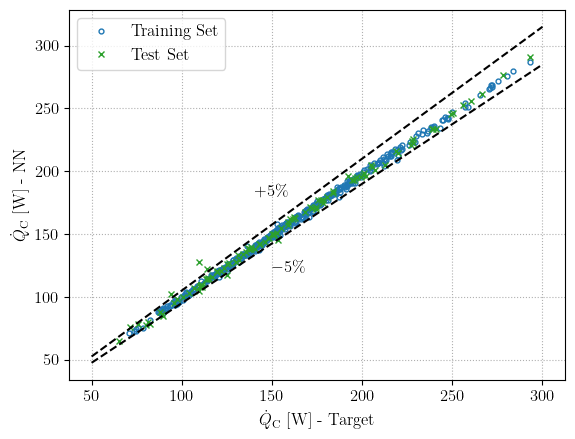

In [123]:
NeuNet(X_train,y_train,1000,'Qc')

INFO:tensorflow:Reloading Oracle from existing project KT_Dir\KT_Hyperband_Wm\oracle.json


INFO:tensorflow:Reloading Oracle from existing project KT_Dir\KT_Hyperband_Wm\oracle.json


INFO:tensorflow:Reloading Tuner from KT_Dir\KT_Hyperband_Wm\tuner0.json


INFO:tensorflow:Reloading Tuner from KT_Dir\KT_Hyperband_Wm\tuner0.json


INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Epoch 1/1000
7/7 [==============================] - 0s 4ms/step - loss: 1.2716 - accuracy: 0.0000e+00
Epoch 2/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.6067 - accuracy: 0.0000e+00
Epoch 3/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.3669 - accuracy: 0.0000e+00
Epoch 4/1000
7/7 [==============================] - 0s 2ms/step - loss: 2.5234 - accuracy: 0.0000e+00
Epoch 5/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.9606 - accuracy: 0.0000e+00
Epoch 6/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.0936 - accuracy: 0.0000e+00
Epoch 7/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.4862 - accuracy: 0.0000e+00
Epoch 8/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.6982 - accuracy: 0.0000e+00
Epoch 9/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.9347 - accuracy: 0.0000e+00
Epoch 10/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.1368 - 

7/7 [==============================] - 0s 1ms/step - loss: 1.1026 - accuracy: 0.0000e+00
Epoch 81/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.2913 - accuracy: 0.0000e+00
Epoch 82/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.9772 - accuracy: 0.0000e+00
Epoch 83/1000
7/7 [==============================] - 0s 2ms/step - loss: 2.2833 - accuracy: 0.0000e+00
Epoch 84/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.2058 - accuracy: 0.0000e+00
Epoch 85/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.5480 - accuracy: 0.0000e+00
Epoch 86/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.5551 - accuracy: 0.0000e+00
Epoch 87/1000
7/7 [==============================] - 0s 2ms/step - loss: 2.4482 - accuracy: 0.0000e+00
Epoch 88/1000
7/7 [==============================] - 0s 2ms/step - loss: 0.5126 - accuracy: 0.0000e+00
Epoch 89/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.8293 - accur

7/7 [==============================] - 0s 2ms/step - loss: 1.9886 - accuracy: 0.0000e+00
Epoch 160/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.2368 - accuracy: 0.0000e+00
Epoch 161/1000
7/7 [==============================] - 0s 1ms/step - loss: 2.5497 - accuracy: 0.0000e+00
Epoch 162/1000
7/7 [==============================] - 0s 2ms/step - loss: 2.0928 - accuracy: 0.0000e+00
Epoch 163/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.8008 - accuracy: 0.0000e+00
Epoch 164/1000
7/7 [==============================] - 0s 2ms/step - loss: 2.5323 - accuracy: 0.0000e+00
Epoch 165/1000
7/7 [==============================] - 0s 2ms/step - loss: 2.0483 - accuracy: 0.0000e+00
Epoch 166/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.0804 - accuracy: 0.0000e+00
Epoch 167/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.2209 - accuracy: 0.0000e+00
Epoch 168/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.058

7/7 [==============================] - 0s 2ms/step - loss: 1.3558 - accuracy: 0.0000e+00
Epoch 238/1000
7/7 [==============================] - 0s 2ms/step - loss: 2.2892 - accuracy: 0.0000e+00
Epoch 239/1000
7/7 [==============================] - 0s 2ms/step - loss: 0.6668 - accuracy: 0.0000e+00
Epoch 240/1000
7/7 [==============================] - 0s 1ms/step - loss: 2.9668 - accuracy: 0.0000e+00
Epoch 241/1000
7/7 [==============================] - 0s 1ms/step - loss: 0.9710 - accuracy: 0.0000e+00
Epoch 242/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.3566 - accuracy: 0.0000e+00
Epoch 243/1000
7/7 [==============================] - 0s 1ms/step - loss: 2.4677 - accuracy: 0.0000e+00
Epoch 244/1000
7/7 [==============================] - 0s 1ms/step - loss: 4.2509 - accuracy: 0.0000e+00
Epoch 245/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.6704 - accuracy: 0.0000e+00
Epoch 246/1000
7/7 [==============================] - 0s 1ms/step - loss: 0.812

7/7 [==============================] - 0s 1ms/step - loss: 1.5407 - accuracy: 0.0000e+00
Epoch 316/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.7226 - accuracy: 0.0000e+00
Epoch 317/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.5742 - accuracy: 0.0000e+00
Epoch 318/1000
7/7 [==============================] - 0s 1ms/step - loss: 3.9138 - accuracy: 0.0000e+00
Epoch 319/1000
7/7 [==============================] - 0s 1ms/step - loss: 2.6958 - accuracy: 0.0000e+00
Epoch 320/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.6434 - accuracy: 0.0000e+00
Epoch 321/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.9117 - accuracy: 0.0000e+00
Epoch 322/1000
7/7 [==============================] - 0s 1ms/step - loss: 2.8996 - accuracy: 0.0000e+00
Epoch 323/1000
7/7 [==============================] - 0s 1ms/step - loss: 0.9592 - accuracy: 0.0000e+00
Epoch 324/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.588

7/7 [==============================] - 0s 1ms/step - loss: 1.9259 - accuracy: 0.0000e+00
Epoch 394/1000
7/7 [==============================] - 0s 2ms/step - loss: 2.6103 - accuracy: 0.0000e+00
Epoch 395/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.5763 - accuracy: 0.0000e+00
Epoch 396/1000
7/7 [==============================] - 0s 2ms/step - loss: 0.9755 - accuracy: 0.0000e+00
Epoch 397/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.4169 - accuracy: 0.0000e+00
Epoch 398/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.3178 - accuracy: 0.0000e+00
Epoch 399/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.1020 - accuracy: 0.0000e+00
Epoch 400/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.6877 - accuracy: 0.0000e+00
Epoch 401/1000
7/7 [==============================] - 0s 1ms/step - loss: 2.2517 - accuracy: 0.0000e+00
Epoch 402/1000
7/7 [==============================] - 0s 1ms/step - loss: 3.671

7/7 [==============================] - 0s 2ms/step - loss: 1.1314 - accuracy: 0.0000e+00
Epoch 472/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.5549 - accuracy: 0.0000e+00
Epoch 473/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.5264 - accuracy: 0.0000e+00
Epoch 474/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.6995 - accuracy: 0.0000e+00
Epoch 475/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.9192 - accuracy: 0.0000e+00
Epoch 476/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.2908 - accuracy: 0.0000e+00
Epoch 477/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.7466 - accuracy: 0.0000e+00
Epoch 478/1000
7/7 [==============================] - 0s 1ms/step - loss: 2.0699 - accuracy: 0.0000e+00
Epoch 479/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.2893 - accuracy: 0.0000e+00
Epoch 480/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.715

7/7 [==============================] - 0s 1ms/step - loss: 1.0365 - accuracy: 0.0000e+00
Epoch 550/1000
7/7 [==============================] - 0s 1ms/step - loss: 2.1786 - accuracy: 0.0000e+00
Epoch 551/1000
7/7 [==============================] - 0s 1ms/step - loss: 2.2763 - accuracy: 0.0000e+00
Epoch 552/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.9680 - accuracy: 0.0000e+00
Epoch 553/1000
7/7 [==============================] - 0s 2ms/step - loss: 0.8544 - accuracy: 0.0000e+00
Epoch 554/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.2051 - accuracy: 0.0000e+00
Epoch 555/1000
7/7 [==============================] - 0s 1ms/step - loss: 0.8017 - accuracy: 0.0000e+00
Epoch 556/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.8596 - accuracy: 0.0000e+00
Epoch 557/1000
7/7 [==============================] - 0s 2ms/step - loss: 0.7000 - accuracy: 0.0000e+00
Epoch 558/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.912

7/7 [==============================] - 0s 1ms/step - loss: 1.7028 - accuracy: 0.0000e+00
Epoch 628/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.2746 - accuracy: 0.0000e+00
Epoch 629/1000
7/7 [==============================] - 0s 1ms/step - loss: 2.4112 - accuracy: 0.0000e+00
Epoch 630/1000
7/7 [==============================] - 0s 1ms/step - loss: 2.0593 - accuracy: 0.0000e+00
Epoch 631/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.3535 - accuracy: 0.0000e+00
Epoch 632/1000
7/7 [==============================] - 0s 1ms/step - loss: 2.1637 - accuracy: 0.0000e+00
Epoch 633/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.3559 - accuracy: 0.0000e+00
Epoch 634/1000
7/7 [==============================] - 0s 1ms/step - loss: 2.3697 - accuracy: 0.0000e+00
Epoch 635/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.7288 - accuracy: 0.0000e+00
Epoch 636/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.138

7/7 [==============================] - 0s 1ms/step - loss: 0.8765 - accuracy: 0.0000e+00
Epoch 706/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.1012 - accuracy: 0.0000e+00
Epoch 707/1000
7/7 [==============================] - 0s 1ms/step - loss: 0.8093 - accuracy: 0.0000e+00
Epoch 708/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.0281 - accuracy: 0.0000e+00
Epoch 709/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.9666 - accuracy: 0.0000e+00
Epoch 710/1000
7/7 [==============================] - 0s 1ms/step - loss: 0.5367 - accuracy: 0.0000e+00
Epoch 711/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.8958 - accuracy: 0.0000e+00
Epoch 712/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.1695 - accuracy: 0.0000e+00
Epoch 713/1000
7/7 [==============================] - 0s 2ms/step - loss: 0.7023 - accuracy: 0.0000e+00
Epoch 714/1000
7/7 [==============================] - 0s 1ms/step - loss: 2.511

7/7 [==============================] - 0s 1ms/step - loss: 1.6697 - accuracy: 0.0000e+00
Epoch 784/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.0631 - accuracy: 0.0000e+00
Epoch 785/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.2152 - accuracy: 0.0000e+00
Epoch 786/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.6034 - accuracy: 0.0000e+00
Epoch 787/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.4882 - accuracy: 0.0000e+00
Epoch 788/1000
7/7 [==============================] - 0s 1ms/step - loss: 0.8426 - accuracy: 0.0000e+00
Epoch 789/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.5136 - accuracy: 0.0000e+00
Epoch 790/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.7428 - accuracy: 0.0000e+00
Epoch 791/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.8362 - accuracy: 0.0000e+00
Epoch 792/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.942

7/7 [==============================] - 0s 1ms/step - loss: 2.5909 - accuracy: 0.0000e+00
Epoch 862/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.6255 - accuracy: 0.0000e+00
Epoch 863/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.2225 - accuracy: 0.0000e+00
Epoch 864/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.1825 - accuracy: 0.0000e+00
Epoch 865/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.8132 - accuracy: 0.0000e+00
Epoch 866/1000
7/7 [==============================] - 0s 1ms/step - loss: 2.0190 - accuracy: 0.0000e+00
Epoch 867/1000
7/7 [==============================] - 0s 1ms/step - loss: 0.6945 - accuracy: 0.0000e+00
Epoch 868/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.1597 - accuracy: 0.0000e+00
Epoch 869/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.4919 - accuracy: 0.0000e+00
Epoch 870/1000
7/7 [==============================] - 0s 1ms/step - loss: 2.820

7/7 [==============================] - 0s 1ms/step - loss: 2.3858 - accuracy: 0.0000e+00
Epoch 940/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.2268 - accuracy: 0.0000e+00
Epoch 941/1000
7/7 [==============================] - 0s 1ms/step - loss: 0.9944 - accuracy: 0.0000e+00
Epoch 942/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.7031 - accuracy: 0.0000e+00
Epoch 943/1000
7/7 [==============================] - 0s 2ms/step - loss: 3.4512 - accuracy: 0.0000e+00
Epoch 944/1000
7/7 [==============================] - 0s 2ms/step - loss: 2.4347 - accuracy: 0.0000e+00
Epoch 945/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.4125 - accuracy: 0.0000e+00
Epoch 946/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.4430 - accuracy: 0.0000e+00
Epoch 947/1000
7/7 [==============================] - 0s 2ms/step - loss: 2.2333 - accuracy: 0.0000e+00
Epoch 948/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.464

INFO:tensorflow:Assets written to: Models/Wm/Wm_NN\assets


14/14 [==============================] - 0s 845us/step
The coefficient of determination for Wm Training Set using Neural Networks is 0.9978108649521877
4/4 [==============================] - 0s 1ms/step
The coefficient of determination for Wm Test Set using Neural Networks is 0.9985791538210685
4/4 [==============================] - 0s 995us/step


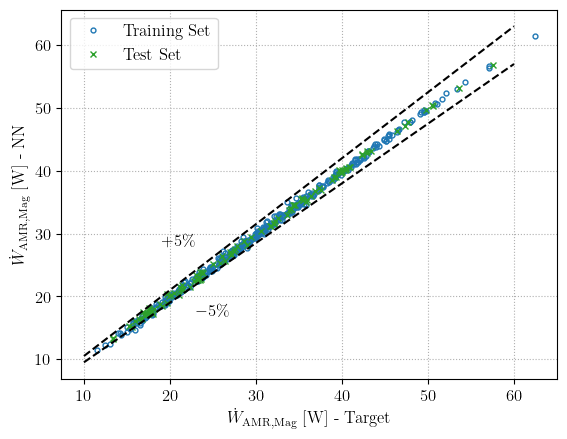

In [124]:
NeuNet(X_train,y_train,1000,'Wm')

### Testing the Models

### Reading the Input Parameteres 

In [11]:
Inputs = pd.read_excel('Data/Data_AMR.xlsx',index_col = 0, dtype=np.float32) # Input Data
X = Inputs[['W','H','f','mf','B','L','Th','Tc']]
y = Inputs[['Qc','Wm']]

### Train-Test Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42)  

### Scaling the Features

In [13]:
Scaller = joblib.load('Models/AMR_Scaler.pkl')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 8)                32        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 69)                621       
                                                                 
 batch_normalization_1 (Batc  (None, 69)               276       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 81)                5670      
                                                                 
 batch_normalization_2 (Batc  (None, 81)               324       
 hNormalization)                                                 
                                                        

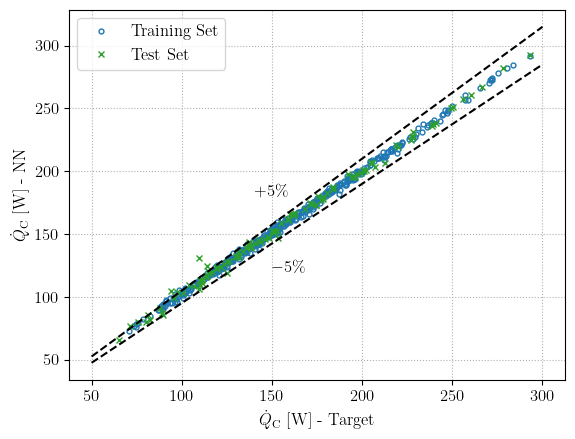

In [114]:
Test(X_train,y_train,'Qc',Scaller)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 8)                32        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 149)               1341      
                                                                 
 batch_normalization_1 (Batc  (None, 149)              596       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 1)                 150       
                                                                 
Total params: 2,119
Trainable params: 1,805
Non-trainable params: 314
_________________________________________________________________
14/14 [==============================] - 0s 2ms/step

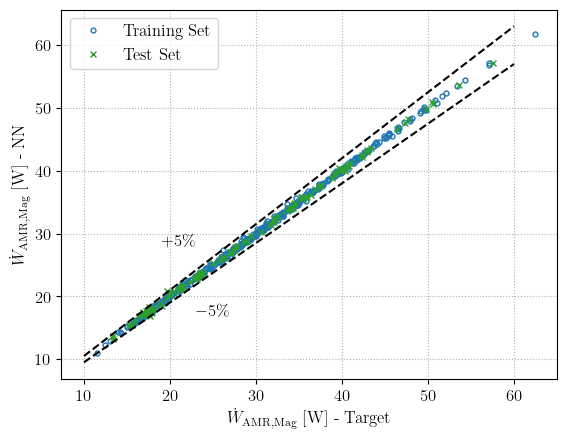

In [115]:
Test(X_train,y_train,'Wm',Scaller)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 8)                32        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 69)                621       
                                                                 
 batch_normalization_1 (Batc  (None, 69)               276       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 81)                5670      
                                                                 
 batch_normalization_2 (Batc  (None, 81)               324       
 hNormalization)                                                 
                                                        

INFO:tensorflow:Assets written to: C:\Users\Guilherme\AppData\Local\Temp\tmpfo9gmtfp\assets


The coefficient of determination for Qc Training Set using Neural Networks is 0.9968712061013907
The coefficient of determination for Qc Test Set using Neural Networks is 0.9944415895932781


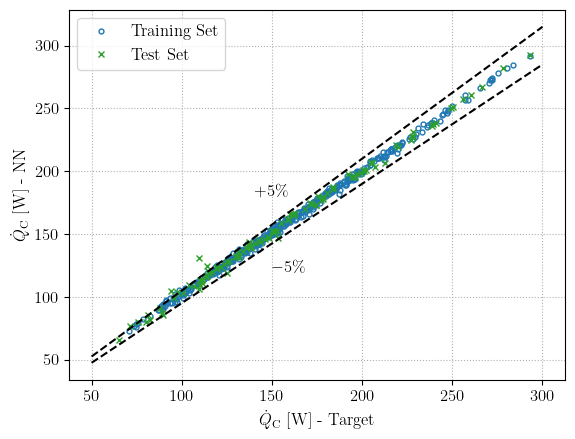

In [117]:
Test_lite(X_train,y_train,'Qc',Scaller)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 8)                32        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 149)               1341      
                                                                 
 batch_normalization_1 (Batc  (None, 149)              596       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 1)                 150       
                                                                 
Total params: 2,119
Trainable params: 1,805
Non-trainable params: 314
_________________________________________________________________
INFO:tensorflow:Assets written to: C:\Users\Guilherm

INFO:tensorflow:Assets written to: C:\Users\Guilherme\AppData\Local\Temp\tmpiy43d0ue\assets


The coefficient of determination for Wm Training Set using Neural Networks is 0.999089908663448
The coefficient of determination for Wm Test Set using Neural Networks is 0.999118178300358


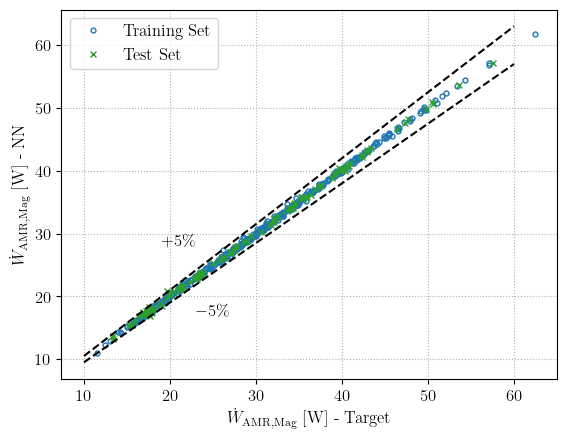

In [119]:
Test_lite(X_train,y_train,'Wm',Scaller)